In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

In [9]:
# Parameters
n = 30 # dimension of actions and/or cost matrix
d = 500 # number of initial sample pairs
total_samples = 10000 # number of total samples that can be used
buff_size = 500 # buffer size of D to make use of newer experiences and limiting the effect of old ones by popping them
alpha = 0.1 # learning rate for when performing gradient descent on b

In [10]:
# Define what you want R to be
# R = np.identity(n) # identity matrix
R = generate_diagonally_dominant_positive_definite_matrix(n)
R = torch.tensor(R, dtype=torch.float32)

In [11]:
# Initialize b to all 2.0s
b = torch.tensor([2.0]*n, requires_grad=True)

In [12]:
# Initialize D to be empty deque
D = deque(maxlen=buff_size)

In [13]:
def generate_diagonally_dominant_positive_definite_matrix(size):
    # add a seed to make the random matrix reproducible
    np.random.seed(42)
    A = np.random.rand(size, size)
    A = A + np.diag(np.sum(np.abs(A), axis=1) + 1)
    A = (A + A.T)/2
    return A

In [14]:
# Cost (reward) function a transpose R a
def reward(a, R):
    return torch.matmul(torch.matmul(a.T,R), a)

In [15]:
# generate a random action given the target parameter b s.t. a = b + N(0,1) (make sure a has entries only [-2,2])
def generate_action(b):
    a = b + torch.normal(0,1,(n,))
    return torch.clamp(a, -2, 2)

In [16]:
# Function for gradient clipping
def clip_gradients(theta, max_norm):
    torch.nn.utils.clip_grad_norm_(theta, max_norm)

In [17]:
# Defining simple MLP for Q where we can change the number of layers and the number of neurons in each layer
class Q_theta(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Q_theta, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

    def loss(self, minibatch):
        loss = 0.0
        for a,r in minibatch:
            loss += (self.forward(a) - r)**2
        loss = loss/len(minibatch)
        return loss

# Initialize Q_theta
Q = Q_theta(n, 1, 64)

In [18]:
optimizer = optim.Adam(Q.parameters(), lr=0.01)

In [19]:
# Function to update the parameters of Q with one step of gradient descent
def update_Q(minibatch, learning_rate, max_norm=None):
    optimizer.zero_grad()  # Reset gradients to zero before backward pass
    loss = Q.loss(minibatch)
    loss.backward(retain_graph=True)  # Perform backpropagation
    if max_norm is not None:
        clip_gradients(Q.parameters(), max_norm=max_norm)  # Gradient clipping

    # Manually update the parameters
    with torch.no_grad():  # Disable gradient tracking to perform manual updates
        for param in Q.parameters():
            param -= learning_rate * param.grad  # Update parameters using gradient descent

In [20]:
# Function to update the parameters of b with one step of gradient descent
def update_b(Q, b):
    # To update b, we need to calculate the gradient w.r.t. to it from the Q network's output (use gradient clipping)
    b_grad = torch.autograd.grad(Q(b.unsqueeze(0)), b, create_graph=True)[0]
    with torch.no_grad():  # Update b without tracking gradients
        b.sub_(alpha * b_grad)
        # Clip gradients using gradient clipping
        clip_gradients(b, max_norm=1.0)

    return b

In [21]:
# Variant 1: BaseMLP with dynamic buffer 
def MLP1():
    global D, b, R

    # list to store the costs to graph them
    zoomcosts = {}

    # Generate initial sample pairs
    for i in range(d):
        a = generate_action(b)
        r = reward(a, R)
        D.append((a,r))

    for i in range(total_samples - d):

        # generate a random action
        a = generate_action(b)

        # get the reward
        r = reward(a, R)

        # add the new sample pair to D
        D.append((a,r))

    # This is the variant area
    #***************************************************************************************************
        # Deque is full, so remove the oldest sample pair
        if len(D) == buff_size:
            D.popleft()
    #***************************************************************************************************

        # sample a minibatch from D
        minibatch = random.sample(D, 32)

        # update Q with one step of gradient descent
        update_Q(minibatch, 0.1, 1.0)

        # update b with one step of gradient descent
        b=update_b(Q,b)

        # print thr reward every 1000 iterations
        if i % 500 == 0:
            print("Cost at iteration ", i, " is ", reward(b, R))
            zoomcosts[i] = reward(b, R)


    # return the costs and the final b
    return reward(b, R), zoomcosts

In [22]:
# variant is clipping the gradients of b as well, using larger learning rate for Q and b, and transforming the buffer to a deque
costs = []
for iter in range(10):
    global b, D, Q
    # set the seed
    torch.manual_seed(iter)
    np.random.seed(iter)

    # reset the parameters
    b = torch.tensor([2.0]*n, requires_grad=True)
    D = deque(maxlen=buff_size)
    Q = Q_theta(n, 1, 64)

    # run the algorithm
    final_cost, zoomcost = MLP1()
    costs.append(final_cost)

/var/folders/22/nrb4t9gx0n9bfqq_y59_73p80000gn/T/ipykernel_30206/2388056880.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  return torch.matmul(torch.matmul(a.T,R), a)


Cost at iteration  0  is  tensor(3662.6172, grad_fn=<DotBackward0>)
Cost at iteration  500  is  tensor(46550.8633, grad_fn=<DotBackward0>)
Cost at iteration  1000  is  tensor(33808.6328, grad_fn=<DotBackward0>)
Cost at iteration  1500  is  tensor(9076.2285, grad_fn=<DotBackward0>)
Cost at iteration  2000  is  tensor(21349.5156, grad_fn=<DotBackward0>)
Cost at iteration  2500  is  tensor(16753.9180, grad_fn=<DotBackward0>)
Cost at iteration  3000  is  tensor(21667.6953, grad_fn=<DotBackward0>)
Cost at iteration  3500  is  tensor(15234.3184, grad_fn=<DotBackward0>)
Cost at iteration  4000  is  tensor(22672.8633, grad_fn=<DotBackward0>)
Cost at iteration  4500  is  tensor(25108.2910, grad_fn=<DotBackward0>)
Cost at iteration  5000  is  tensor(10853.1152, grad_fn=<DotBackward0>)
Cost at iteration  5500  is  tensor(10988.1426, grad_fn=<DotBackward0>)
Cost at iteration  6000  is  tensor(10801.1797, grad_fn=<DotBackward0>)
Cost at iteration  6500  is  tensor(8333.1787, grad_fn=<DotBackward0>)

In [25]:
print(costs)
# print the mean cost (they are tensor objects)
print(torch.mean(torch.tensor(costs)))

[tensor(19239.3652, grad_fn=<DotBackward0>), tensor(12916.3789, grad_fn=<DotBackward0>), tensor(15972.0469, grad_fn=<DotBackward0>), tensor(8504.5605, grad_fn=<DotBackward0>), tensor(25890.3613, grad_fn=<DotBackward0>), tensor(85982.0312, grad_fn=<DotBackward0>), tensor(41012.6328, grad_fn=<DotBackward0>), tensor(9877.0332, grad_fn=<DotBackward0>), tensor(697954.3750, grad_fn=<DotBackward0>), tensor(30777.4199, grad_fn=<DotBackward0>)]
tensor(94812.6328)


In [26]:
# convert the costs to a numpy array using detach
costs = torch.tensor(costs).detach().numpy()

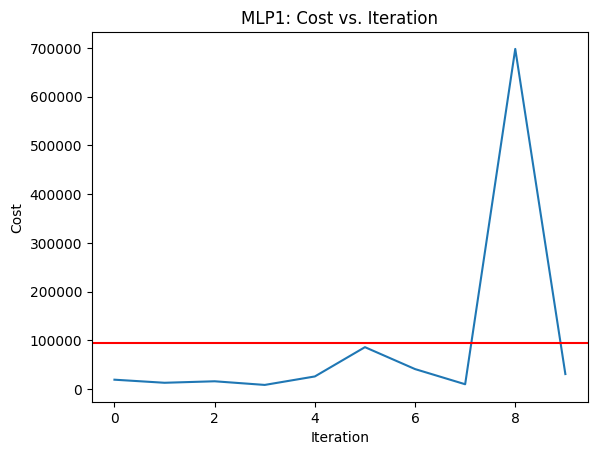

In [29]:
# graph the costs
import matplotlib.pyplot as plt
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('MLP1: Cost vs. Iteration')
mean = costs.mean()
plt.axhline(y=mean, color='r', linestyle='-', label='Mean Cost')
# plt.show()
# save the figure
plt.savefig('MLP1.png')

In [30]:
zoomcost = dict(zoomcost)

# convert the zoomcosts to a python dictionary

def tensors_to_numpy(tensor_dict):
    numpy_dict = {}
    for key, tensor in tensor_dict.items():
        # Ensure tensor is on CPU before converting
        numpy_dict[key] = tensor.cpu().numpy()
    return numpy_dict

# convert the zoomcosts to a regular dictionary
# zoomcost = tensors_to_numpy(zoomcost)
print(zoomcost)

{0: tensor(3663.4385, grad_fn=<DotBackward0>), 500: tensor(35396.0625, grad_fn=<DotBackward0>), 1000: tensor(23485.6035, grad_fn=<DotBackward0>), 1500: tensor(9360.9160, grad_fn=<DotBackward0>), 2000: tensor(17959.7520, grad_fn=<DotBackward0>), 2500: tensor(20493.7988, grad_fn=<DotBackward0>), 3000: tensor(14270.7725, grad_fn=<DotBackward0>), 3500: tensor(15092.5312, grad_fn=<DotBackward0>), 4000: tensor(19380.4707, grad_fn=<DotBackward0>), 4500: tensor(13368.3691, grad_fn=<DotBackward0>), 5000: tensor(33860.6016, grad_fn=<DotBackward0>), 5500: tensor(62950.2500, grad_fn=<DotBackward0>), 6000: tensor(12869.3535, grad_fn=<DotBackward0>), 6500: tensor(24398.8672, grad_fn=<DotBackward0>), 7000: tensor(12896.5332, grad_fn=<DotBackward0>), 7500: tensor(46748.6289, grad_fn=<DotBackward0>), 8000: tensor(15550.7822, grad_fn=<DotBackward0>), 8500: tensor(23833.4688, grad_fn=<DotBackward0>), 9000: tensor(14479.3594, grad_fn=<DotBackward0>)}
